In [1]:
# Argparse
import argparse
opt = argparse.Namespace( # Fake parsed arguments
    seed=7,
    device=-1,
    cuda=False,
    visdom=True
)

# Util
import cdae.util as util
util.init(opt)

# Model
import cdae.models.quadratic as quadratic


# Torch
import torch
from torch.autograd import Variable
import torch.optim as optim

# Plotting
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.available
plt.style.use('seaborn-whitegrid')

%matplotlib notebook

# Stats
import scipy.stats

# Generative Model

The true generative model $p$ over latents $k, x$ and observed variables $y$ is:
\begin{align}
    k &\sim \mathrm{Categorical}([2, 5], [0.5, 0.5]) \\\
    x &\sim \mathrm{Normal}(0, 1) \\\
    y &\sim \mathrm{Normal}(f(k, x) ,1)
\end{align}
where $f: \mathbb R^2 \to \mathbb R$ is defined as
\begin{align}
    f(k, x) = a(k + x)^2 + b(k + x) + c.
\end{align}


<IPython.core.display.Javascript object>


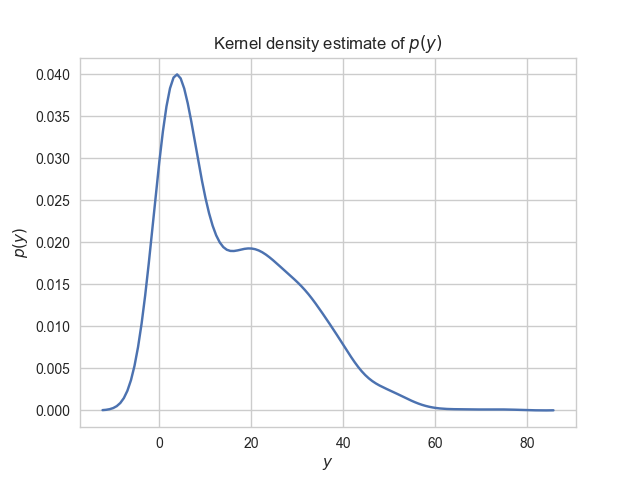

In [2]:
generative_model = quadratic.GenerativeModel(a=1, b=0, c=0)
num_data = 1000
_, _, y = generative_model.sample(num_data)
y = y.squeeze(1).numpy()
fig, ax = plt.subplots()
sns.kdeplot(y, ax=ax)
ax.set_title('Kernel density estimate of $p(y)$')
ax.set_xlabel('$y$')
ax.set_ylabel('$p(y)$')

# Generative Network

Assume that we actually don't know the form of $f$ and that we want to learn it, i.e. the true model $p$ from a dataset $(y^{(n)})_{n = 1}^N$.
Let's model the family of functions $f$ under consideration as a neural network parameterized by generative weights $\theta$ such that it maps from $\mathbb R^2$ to $\mathbb R$:

<IPython.core.display.Javascript object>


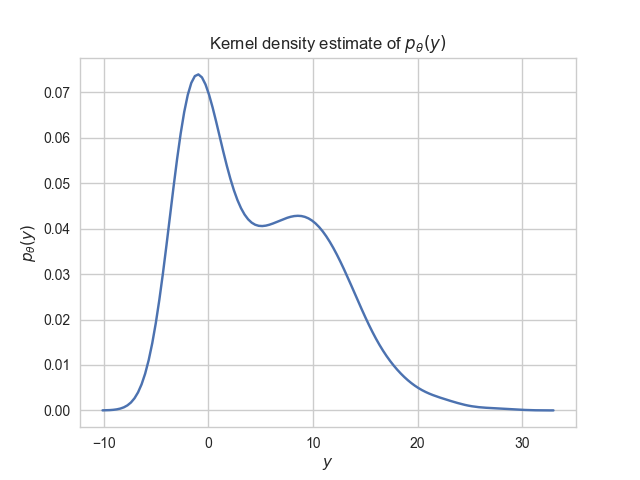

In [3]:
generative_network = quadratic.GenerativeNetwork()
num_data = 1000
_, _, y = generative_network.sample(num_data)
y = y.squeeze(1).numpy()

fig, ax = plt.subplots()
sns.kdeplot(y, ax=ax)
ax.set_title('Kernel density estimate of $p_{\\theta}(y)$')
ax.set_xlabel('$y$')
ax.set_ylabel('$p_{\\theta}(y)$')

# Inference Network

We seek to learn an inference network $q_{\phi}(k, x \lvert y)$ parameterized by $\phi$ which, given $y$ maps to the parameters of the distribution over $(k, x)$, ideally close to the posterior under the true model, $p(k, x \lvert y)$.

Let
\begin{align}
    q_{\phi}(k, x \lvert y) &= q_{\phi}(k \lvert y) q_{\phi}(x \lvert k, y) \\\
    q_{\phi}(k \lvert y) &= \mathrm{Categorical}([2, 5], [\phi_1, \phi_2]) \\\
    q_{\phi}(x \lvert k, y) &= \mathrm{Normal}(\phi_3, \phi_4)
\end{align}
where $\phi = [\phi_1, \dotsc, \phi_4]$ is the output of the inference network.

In [4]:
inference_network = quadratic.InferenceNetwork()
_, _, y_test = generative_model.sample(1)
y_test = generative_model.sample(1)[2][0][0]
y_test

25.592905044555664

<IPython.core.display.Javascript object>


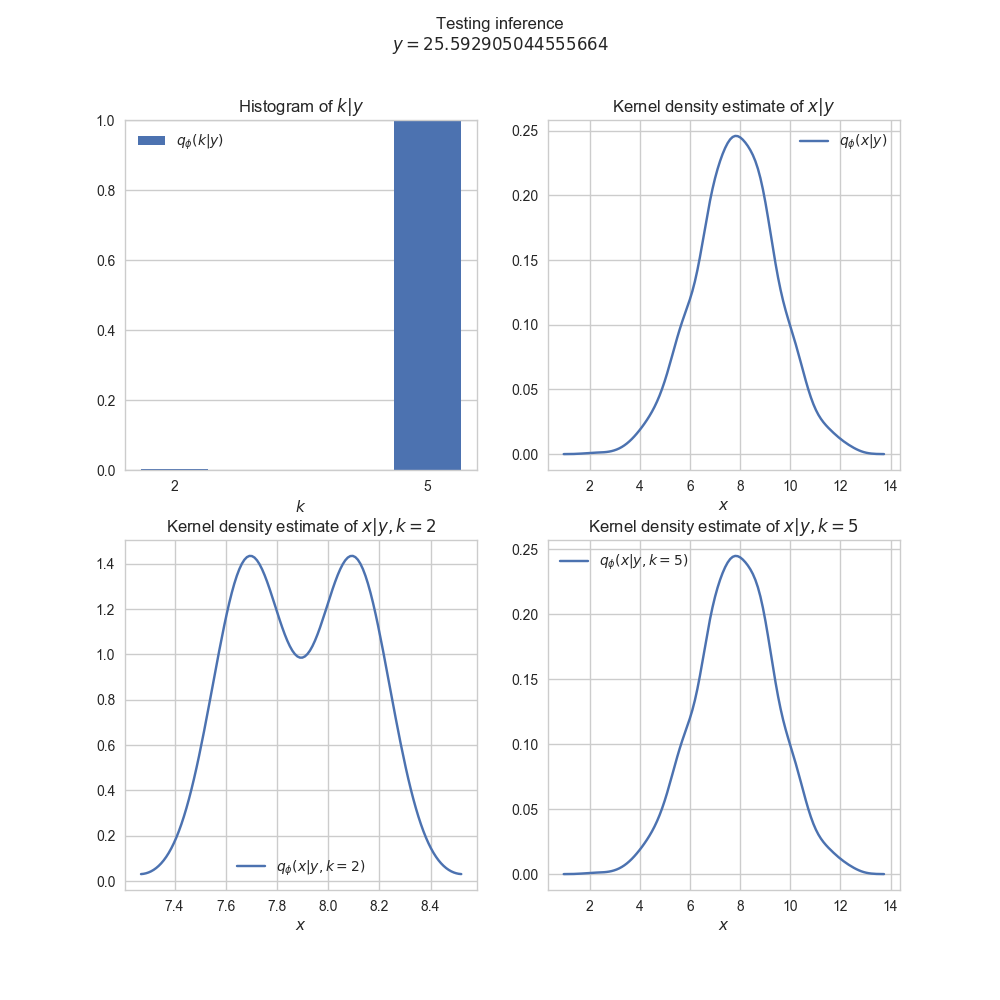

In [5]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)
fig.suptitle('Testing inference\n$y = {}$'.format(y_test))
bar_width = 0.8

##############
##############
##############

num_inference_network_samples = 1000
y = torch.Tensor([[y_test]]).expand(num_inference_network_samples, 1)
k, x = inference_network.sample(y)

values = [2, 5]
normalized_weights = [
    torch.sum(k == 2) / len(k),
    torch.sum(k == 5) / len(k),
]
bar1 = ax[0][0].bar(np.array(values), normalized_weights, width=bar_width, tick_label=values, color=colors[0], label='$q_{\phi}(k | y)$')
sns.kdeplot(x.view(-1).numpy(), ax=ax[0][1], label='$q_{\phi}(x | y)$', color=colors[0])

if len(x[k == 2]) != 0:
    sns.kdeplot(x[k == 2].view(-1).numpy(), ax=ax[1][0], label='$q_{\phi}(x | y, k = 2)$', color=colors[0])
else:
    ax[1][0].axhline(0, label='$q_{\phi}(x | y, k = 2)$', color=colors[0])

if len(x[k == 5]) != 0:
    sns.kdeplot(x[k == 5].view(-1).numpy(), ax=ax[1][1], label='$q_{\phi}(x | y, k = 5)$', color=colors[0])
else:
    ax[1][1].axhline(0, label='$q_{\phi}(x | y, k = 5)$', color=colors[0])

##############
##############
##############

ax[0][0].xaxis.grid(False)
ax[0][0].set_ylim([0, 1])
ax[0][0].set_title('Histogram of $k | y$')
ax[0][0].set_xlabel('$k$')
ax[0][0].legend()

ax[0][1].set_title('Kernel density estimate of $x | y$')
ax[0][1].set_xlabel('$x$')

ax[1][0].set_title('Kernel density estimate of $x | y, k = 2$')
ax[1][0].set_xlabel('$x$')

ax[1][1].set_title('Kernel density estimate of $x | y, k = 5$')
ax[1][1].set_xlabel('$x$')
ax[1][1].legend()

# Training Loop

In [6]:
inference_network = quadratic.InferenceNetwork()
generative_network = quadratic.GenerativeNetwork()

inference_network_optim = optim.Adam(inference_network.parameters())
generative_network_optim = optim.Adam(generative_network.parameters())

num_iterations = 10
batch_size = 100
num_data = 1000
generative_epochs_per_iteration = 50
inference_epochs_per_iteration = 10
num_generative_epochs = np.repeat(generative_epochs_per_iteration, num_iterations)
num_inference_epochs = np.repeat(inference_epochs_per_iteration, num_iterations)

data_generator = lambda: generative_model.sample(1)[2][0][0]
quadratic_dataset = quadratic.Dataset(infinite_data=False, num_data=num_data, data_generator=data_generator)
quadratic_dataloader = torch.utils.data.DataLoader(quadratic_dataset, batch_size=batch_size, shuffle=True)

generative_network_objective = []
inference_network_objective = []
if opt.visdom:
    util.vis.close()
    generative_network_objective_line = util.vis.line(
        X=np.array([0]), 
        Y=np.array([0]),
        opts=dict(
            xlabel='Epoch',
            ylabel='Objective (to maximize)',
            title='Generative network objective'
        )
    )
    
    inference_network_objective_line = util.vis.line(
        X=np.array([0]), 
        Y=np.array([0]),
        opts=dict(
            xlabel='Epoch',
            ylabel='Objective (to minimize)',
            title='Inference network objective'
        )
    )

for i in range(num_iterations):
    util.logger.info('Iteration {}'.format(i))
    
    # Step 1
    for epoch in range(num_generative_epochs[i]):
        temp_generative_network_objective = []
        for _, y in enumerate(quadratic_dataloader):
            k, x = inference_network.sample(y.unsqueeze(1))
            
            generative_network_optim.zero_grad()
            logpdf_generative_network = generative_network.forward(Variable(k), Variable(x), Variable(y))
            temp_generative_network_objective += logpdf_generative_network.data.numpy().tolist()
            utility = torch.mean(logpdf_generative_network)
            loss = -utility # we want to maximize
            loss.backward()
            generative_network_optim.step()
        generative_network_objective.append(np.mean(temp_generative_network_objective))
        
        util.vis.line(
            X=np.arange(len(generative_network_objective)),
            Y=np.nan_to_num(np.array(generative_network_objective)),
            update='replace',
            win=generative_network_objective_line
        )
        util.logger.info('Generative network step | Epoch {0} | Objective {1}'.format(epoch, generative_network_objective[-1]))
    
    # Step 2
    for epoch in range(num_inference_epochs[i]):
        temp_inference_network_objective = []
        for batch_size in util.chunk(num_data, batch_size):
            k, x, y = generative_network.sample(batch_size)
            
            inference_network_optim.zero_grad()
            logpdf_inference_network = inference_network.forward(Variable(k), Variable(x), Variable(y))
            temp_inference_network_objective += (-logpdf_inference_network).data.numpy().tolist()
            loss = torch.mean(-logpdf_inference_network)
            loss.backward()
            inference_network_optim.step()
        inference_network_objective.append(np.mean(temp_inference_network_objective))
        util.vis.line(
            X=np.arange(len(inference_network_objective)),
            Y=np.nan_to_num(np.array(inference_network_objective)),
            update='replace',
            win=inference_network_objective_line
        )
        util.logger.info('Inference network step | Epoch {0} | Objective {1}'.format(epoch, inference_network_objective[-1]))

2017-07-21 23:07:07,236: Iteration 0
2017-07-21 23:07:07,287: Generative network step | Epoch 0 | Objective -37662.16088005114
2017-07-21 23:07:07,339: Generative network step | Epoch 1 | Objective -36513.17677338076
2017-07-21 23:07:07,392: Generative network step | Epoch 2 | Objective -35400.25744574952
2017-07-21 23:07:07,443: Generative network step | Epoch 3 | Objective -34290.49123995042
2017-07-21 23:07:07,494: Generative network step | Epoch 4 | Objective -33220.172516426566
2017-07-21 23:07:07,546: Generative network step | Epoch 5 | Objective -32205.195311502932
2017-07-21 23:07:07,599: Generative network step | Epoch 6 | Objective -31243.389795883893
2017-07-21 23:07:07,653: Generative network step | Epoch 7 | Objective -30220.385148693083
2017-07-21 23:07:07,753: Generative network step | Epoch 8 | Objective -29251.79206252575
2017-07-21 23:07:07,803: Generative network step | Epoch 9 | Objective -28278.320312207936
2017-07-21 23:07:07,858: Generative network step | Epoch 1

2017-07-21 23:07:12,111: Generative network step | Epoch 30 | Objective -1029.459357621193
2017-07-21 23:07:12,165: Generative network step | Epoch 31 | Objective -1031.5334640891551
2017-07-21 23:07:12,221: Generative network step | Epoch 32 | Objective -1027.9640753116607
2017-07-21 23:07:12,276: Generative network step | Epoch 33 | Objective -1007.8142575583458
2017-07-21 23:07:12,331: Generative network step | Epoch 34 | Objective -944.223089501381
2017-07-21 23:07:12,386: Generative network step | Epoch 35 | Objective -957.3972324180603
2017-07-21 23:07:12,441: Generative network step | Epoch 36 | Objective -896.871377546072
2017-07-21 23:07:12,495: Generative network step | Epoch 37 | Objective -942.8127159655094
2017-07-21 23:07:12,547: Generative network step | Epoch 38 | Objective -911.8826029765606
2017-07-21 23:07:12,603: Generative network step | Epoch 39 | Objective -851.3401725111007
2017-07-21 23:07:12,659: Generative network step | Epoch 40 | Objective -843.831772322893

2017-07-21 23:07:16,814: Iteration 3
2017-07-21 23:07:16,866: Generative network step | Epoch 0 | Objective -117.51717365145683
2017-07-21 23:07:16,921: Generative network step | Epoch 1 | Objective -118.83682035160065
2017-07-21 23:07:16,974: Generative network step | Epoch 2 | Objective -115.50882740306854
2017-07-21 23:07:17,027: Generative network step | Epoch 3 | Objective -116.93014827418327
2017-07-21 23:07:17,076: Generative network step | Epoch 4 | Objective -119.54669062972069
2017-07-21 23:07:17,128: Generative network step | Epoch 5 | Objective -124.07960358166694
2017-07-21 23:07:17,177: Generative network step | Epoch 6 | Objective -116.99550080513954
2017-07-21 23:07:17,229: Generative network step | Epoch 7 | Objective -117.68144168066978
2017-07-21 23:07:17,280: Generative network step | Epoch 8 | Objective -123.54854956316947
2017-07-21 23:07:17,333: Generative network step | Epoch 9 | Objective -116.8687394542694
2017-07-21 23:07:17,383: Generative network step | Epo

2017-07-21 23:07:21,433: Generative network step | Epoch 29 | Objective -99.77490812945366
2017-07-21 23:07:21,483: Generative network step | Epoch 30 | Objective -104.59504716658593
2017-07-21 23:07:21,533: Generative network step | Epoch 31 | Objective -100.43595419812202
2017-07-21 23:07:21,583: Generative network step | Epoch 32 | Objective -98.44634036254882
2017-07-21 23:07:21,633: Generative network step | Epoch 33 | Objective -98.19167734265328
2017-07-21 23:07:21,685: Generative network step | Epoch 34 | Objective -97.09223197507858
2017-07-21 23:07:21,734: Generative network step | Epoch 35 | Objective -102.73724287223816
2017-07-21 23:07:21,785: Generative network step | Epoch 36 | Objective -99.58437073898315
2017-07-21 23:07:21,836: Generative network step | Epoch 37 | Objective -93.80759504127502
2017-07-21 23:07:21,885: Generative network step | Epoch 38 | Objective -92.78777452850342
2017-07-21 23:07:21,936: Generative network step | Epoch 39 | Objective -93.66372292733

2017-07-21 23:07:26,080: Iteration 6
2017-07-21 23:07:26,132: Generative network step | Epoch 0 | Objective -57.45282596945763
2017-07-21 23:07:26,187: Generative network step | Epoch 1 | Objective -55.70223167705536
2017-07-21 23:07:26,238: Generative network step | Epoch 2 | Objective -56.8271022400856
2017-07-21 23:07:26,292: Generative network step | Epoch 3 | Objective -54.42730502414703
2017-07-21 23:07:26,343: Generative network step | Epoch 4 | Objective -55.17251472687721
2017-07-21 23:07:26,393: Generative network step | Epoch 5 | Objective -52.437152057886124
2017-07-21 23:07:26,446: Generative network step | Epoch 6 | Objective -54.332844833374025
2017-07-21 23:07:26,495: Generative network step | Epoch 7 | Objective -51.999112347364424
2017-07-21 23:07:26,596: Generative network step | Epoch 8 | Objective -52.12266963529587
2017-07-21 23:07:26,645: Generative network step | Epoch 9 | Objective -51.35357184553146
2017-07-21 23:07:26,694: Generative network step | Epoch 10 |

2017-07-21 23:07:30,738: Generative network step | Epoch 29 | Objective -24.868654430389405
2017-07-21 23:07:30,789: Generative network step | Epoch 30 | Objective -24.448671022176743
2017-07-21 23:07:30,839: Generative network step | Epoch 31 | Objective -24.42170206284523
2017-07-21 23:07:30,891: Generative network step | Epoch 32 | Objective -24.611746854543686
2017-07-21 23:07:30,941: Generative network step | Epoch 33 | Objective -24.32613259458542
2017-07-21 23:07:30,993: Generative network step | Epoch 34 | Objective -24.15351895904541
2017-07-21 23:07:31,048: Generative network step | Epoch 35 | Objective -23.975703147888183
2017-07-21 23:07:31,097: Generative network step | Epoch 36 | Objective -23.486227483034135
2017-07-21 23:07:31,150: Generative network step | Epoch 37 | Objective -23.12925168967247
2017-07-21 23:07:31,201: Generative network step | Epoch 38 | Objective -23.518269661426544
2017-07-21 23:07:31,251: Generative network step | Epoch 39 | Objective -23.53842261

2017-07-21 23:07:35,385: Inference network step | Epoch 9 | Objective 0.8154899664167314
2017-07-21 23:07:35,386: Iteration 9
2017-07-21 23:07:35,438: Generative network step | Epoch 0 | Objective -14.963719107151032
2017-07-21 23:07:35,491: Generative network step | Epoch 1 | Objective -14.976965021371841
2017-07-21 23:07:35,542: Generative network step | Epoch 2 | Objective -14.761158853292466
2017-07-21 23:07:35,591: Generative network step | Epoch 3 | Objective -14.837784289121627
2017-07-21 23:07:35,643: Generative network step | Epoch 4 | Objective -14.907088781833648
2017-07-21 23:07:35,692: Generative network step | Epoch 5 | Objective -14.733389291763306
2017-07-21 23:07:35,741: Generative network step | Epoch 6 | Objective -14.4824669611454
2017-07-21 23:07:35,793: Generative network step | Epoch 7 | Objective -14.531556293964385
2017-07-21 23:07:35,843: Generative network step | Epoch 8 | Objective -14.390823644638061
2017-07-21 23:07:35,894: Generative network step | Epoch 

<IPython.core.display.Javascript object>


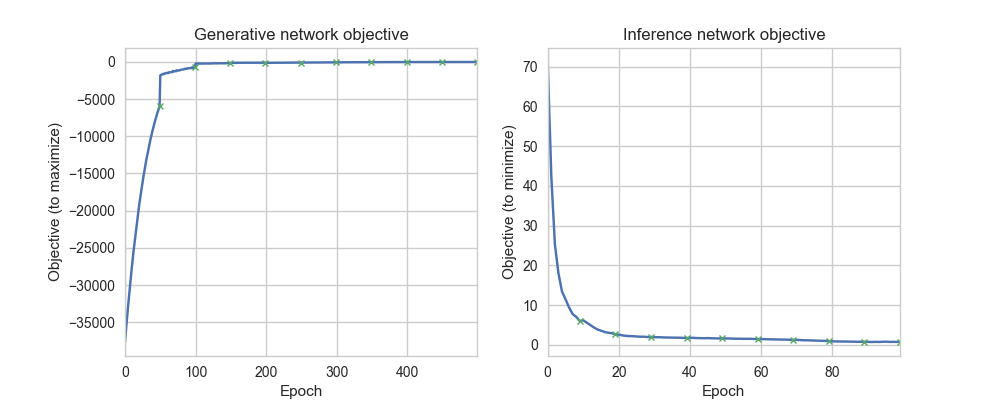

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10, 4)
ax[0].plot(
    np.arange(len(generative_network_objective)),
    np.nan_to_num(generative_network_objective)
)
ax[0].plot(
    np.cumsum(num_generative_epochs) - 1,
    np.nan_to_num(np.array(generative_network_objective)[np.cumsum(num_generative_epochs) - 1]),
    linestyle='None',
    marker='x',
    markersize=5,
    markeredgewidth=1
)
ax[0].set_xlim([0, len(generative_network_objective) - 1])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Objective (to maximize)')
ax[0].set_title('Generative network objective')

ax[1].plot(
    np.arange(len(inference_network_objective)),
    np.nan_to_num(inference_network_objective)
)
ax[1].plot(
    np.cumsum(num_inference_epochs) - 1,
    np.nan_to_num(np.array(inference_network_objective)[np.cumsum(num_inference_epochs) - 1]),
    linestyle='None',
    marker='x',
    markersize=5,
    markeredgewidth=1
)
ax[1].set_xlim([0, len(inference_network_objective) - 1])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Objective (to minimize)')
ax[1].set_title('Inference network objective')

fig.savefig('./figures/training.pdf', bbox_inches='tight')

# Testing the Generative Model

<IPython.core.display.Javascript object>


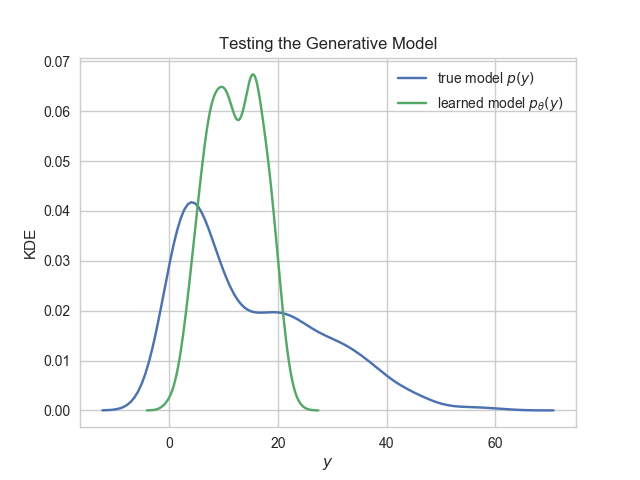

In [8]:
fig, ax = plt.subplots()
num_data = 1000

# generative_model = quadratic.GenerativeModel()
_, _, y = generative_model.sample(num_data)
y = y.squeeze(1).numpy()
sns.kdeplot(y, ax=ax, label='true model $p(y)$')

_, _, y = generative_network.sample(num_data)
y = y.squeeze(1).numpy()
sns.kdeplot(y, ax=ax, label='learned model $p_{\\theta}(y)$')

ax.set_ylabel('KDE')
ax.set_xlabel('$y$')
ax.set_title('Testing the Generative Model')

fig.savefig('./figures/generative.pdf', bbox_inches='tight')

# Testing Inference

In [9]:
_, _, y_test = generative_model.sample(1)
y_test = generative_model.sample(1)[2][0][0]
y_test

23.70816421508789

<IPython.core.display.Javascript object>


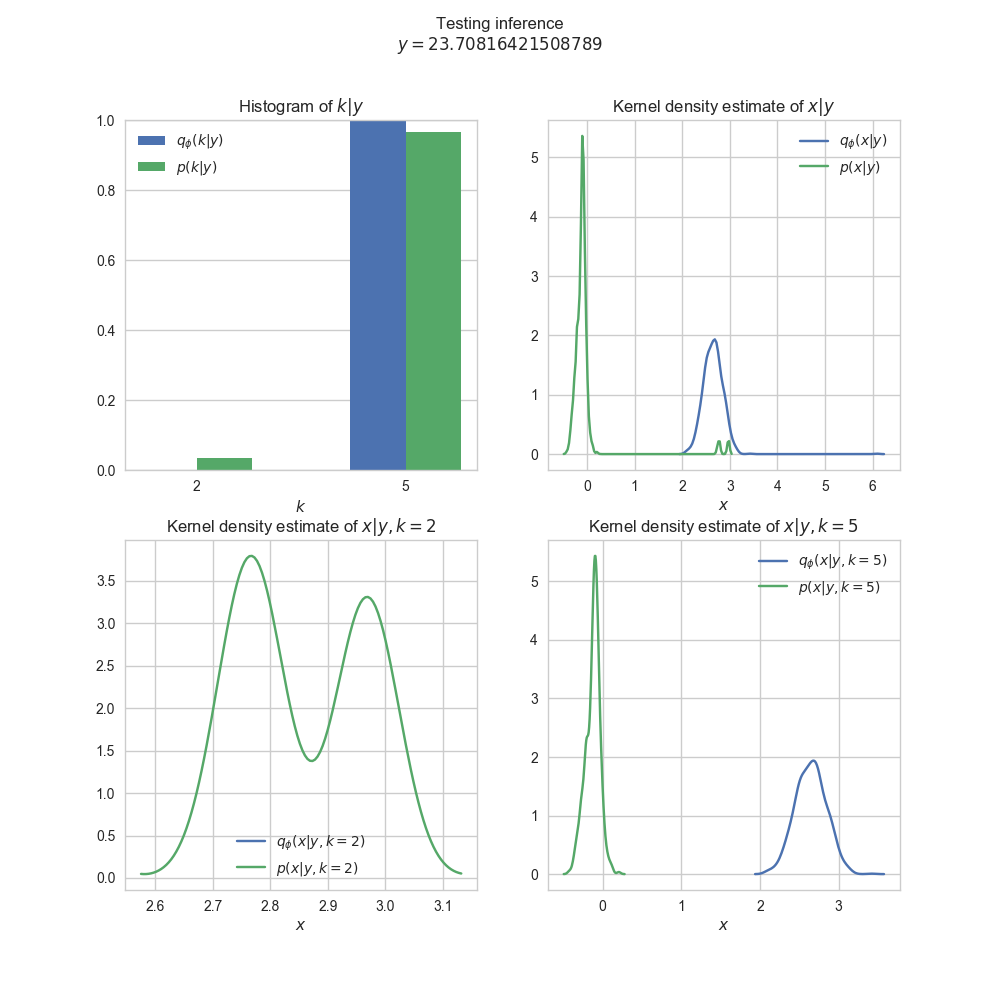

/Users/tuananhle/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/tuananhle/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)
fig.suptitle('Testing inference\n$y = {}$'.format(y_test))
bar_width = 0.8

##############
##############
##############

num_inference_network_samples = 1000
y = torch.Tensor([[y_test]]).expand(num_inference_network_samples, 1)
k, x = inference_network.sample(y)

values = [2, 5]
normalized_weights = [
    torch.sum(k == 2) / len(k),
    torch.sum(k == 5) / len(k),
]
bar1 = ax[0][0].bar(np.array(values) - bar_width / 2, normalized_weights, width=bar_width, tick_label=values, color=colors[0], label='$q_{\phi}(k | y)$')
sns.kdeplot(x.view(-1).numpy(), ax=ax[0][1], label='$q_{\phi}(x | y)$', color=colors[0])

if len(x[k == 2]) != 0:
    sns.kdeplot(x[k == 2].view(-1).numpy(), ax=ax[1][0], label='$q_{\phi}(x | y, k = 2)$', color=colors[0])
else:
    ax[1][0].axhline(0, label='$q_{\phi}(x | y, k = 2)$', color=colors[0])

if len(x[k == 5]) != 0:
    sns.kdeplot(x[k == 5].view(-1).numpy(), ax=ax[1][1], label='$q_{\phi}(x | y, k = 5)$', color=colors[0])
else:
    ax[1][1].axhline(0, label='$q_{\phi}(x | y, k = 5)$', color=colors[0])

##############
##############
##############

num_particles = 1000
num_posterior_samples = 1000
k, x = generative_model.importance_sample(y_test, num_particles, resample=True, num_resample=num_posterior_samples)

values = [2, 5]
normalized_weights = [
    sum(k == 2) / len(k),
    sum(k == 5) / len(k),
]
bar2 = ax[0][0].bar(np.array(values) + bar_width / 2, normalized_weights, tick_label=values, label='$p(k | y)$', color=colors[1])

sns.distplot(x.numpy(), hist=False, ax=ax[0][1], label='$p(x | y)$', color=colors[1])

if normalized_weights[0] != 0:
    sns.distplot(
        x[k == 2].numpy(), 
        hist=False,
        ax=ax[1][0],
        label='$p(x | y, k = 2)$',
        color=colors[1]
    )
else:
    ax[1][0].axhline(0, label='$p(x | y, k = 2)$', color=colors[1])

if normalized_weights[1] != 0:
    sns.distplot(
        x[k == 5].numpy(), 
        hist=False,
        ax=ax[1][1],
        label='$p(x | y, k = 5)$',
        color=colors[1]
    )
else:
    ax[1][1].axhline(0, label='$p(x | y, k = 5)$', color=colors[1])

##############
##############
##############

ax[0][0].set_xticks(np.array([2, 5]))
ax[0][0].xaxis.grid(False)
ax[0][0].set_ylim([0, 1])
ax[0][0].set_title('Histogram of $k | y$')
ax[0][0].set_xlabel('$k$')
ax[0][0].legend()

ax[0][1].set_title('Kernel density estimate of $x | y$')
ax[0][1].set_xlabel('$x$')

ax[1][0].set_title('Kernel density estimate of $x | y, k = 2$')
ax[1][0].set_xlabel('$x$')

ax[1][1].set_title('Kernel density estimate of $x | y, k = 5$')
ax[1][1].set_xlabel('$x$')
ax[1][1].legend()

fig.savefig('./figures/inference.pdf', bbox_inches='tight')